/Users/a.j.sager/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:53:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Accuracy: 0.74


/Users/a.j.sager/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:53:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/a.j.sager/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:53:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/a.j.sager/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:53:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/a.j.sager/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:53:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

Cross-Validation Accuracy Scores: [0.7109375  0.7578125  0.734375   0.8125     0.63779528]
Mean CV Accuracy: 0.73
Standard Deviation of CV Accuracy: 0.06


<Figure size 1000x600 with 0 Axes>

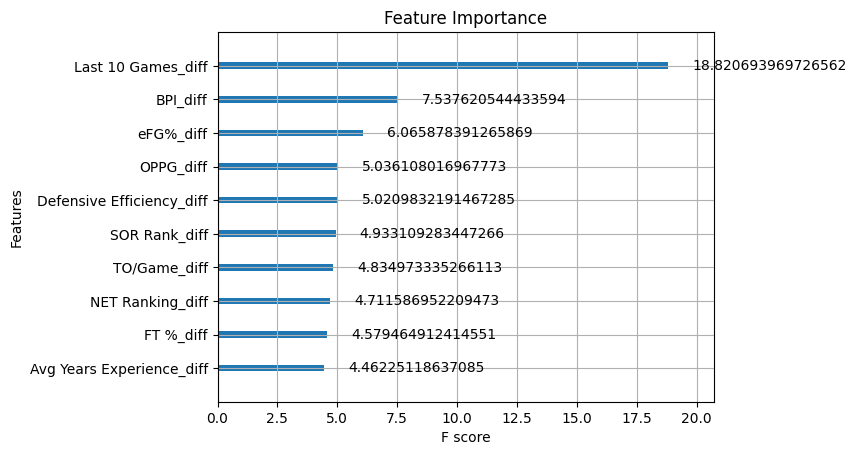

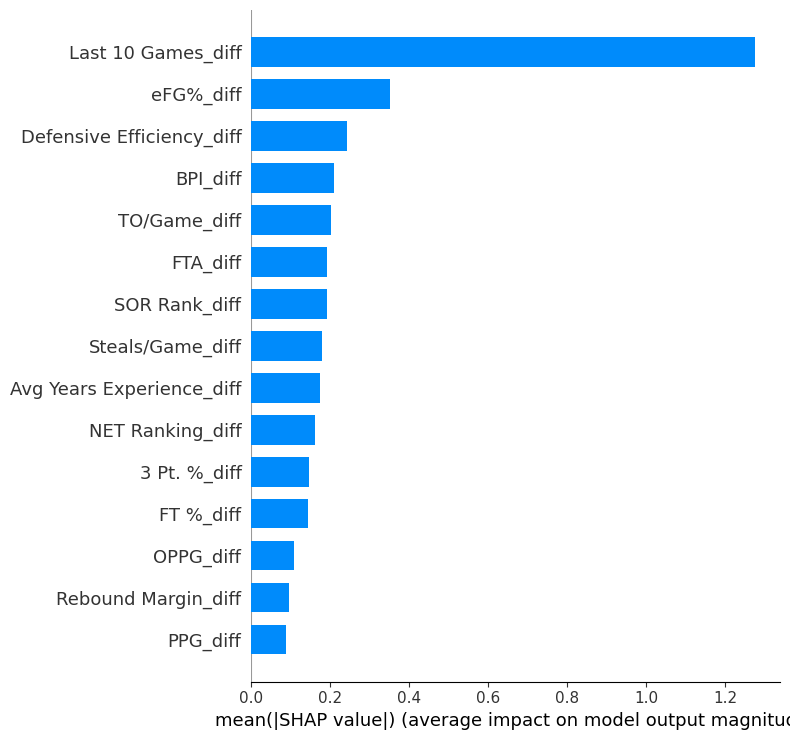

The chance of Auburn beating Alabama State is 94.66%
The chance of Louisville beating Creighton is 64.62%
The chance of Michigan beating UC San Diego is 73.22%
The chance of Texas A&M beating Yale is 48.38%
The chance of Ole Miss beating North Carolina is 6.21%
The chance of Iowa State beating Lipscomb is 82.43%
The chance of Marquette beating New Mexico is 80.90%
The chance of Michigan State beating Bryant is 94.16%
The chance of Auburn beating Louisville is 72.19%
The chance of Michigan beating Yale is 93.35%
The chance of North Carolina beating Iowa State is 31.63%
The chance of Marquette beating Michigan State is 7.27%
The chance of Auburn beating Michigan is 38.60%
The chance of Iowa State beating Michigan State is 51.81%
The chance of Michigan beating Iowa State is 70.88%
The chance of Florida beating Norfolk State is 92.42%
The chance of UConn beating Oklahoma is 47.78%
The chance of Memphis beating Colorado State is 26.19%
The chance of Maryland beating Grand Canyon is 91.03%
T

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import shap

# Load data
game_results = pd.read_csv('/Users/a.j.sager/Desktop/March Madness Code/game_results_2025.csv')
team_stats = pd.read_csv('/Users/a.j.sager/Desktop/March Madness Code/2024-2025 March Madness Data.csv', encoding="ISO-8859-1")

# Merge datasets on team 1 and team 2
merged = game_results.merge(
    team_stats, left_on="team_1", right_on="Team", how="left", suffixes=("", "_team1")
).merge(
    team_stats, left_on="team_2", right_on="Team", how="left", suffixes=("", "_team2")
)

# Drop redundant columns and handle missing values
merged = merged.drop(columns=["Team", "Team_team2"])
merged.dropna(subset=['outcome'], inplace=True)

# Feature columns
stat_columns = [
    "PPG", "OPPG", "TO/Game", "3 Pt. %", "eFG%", "FTA", "FT %", 
    "Steals/Game", "Rebound Margin", "NET Ranking", "SOR Rank", "BPI", 
    "Avg Years Experience", "Defensive Efficiency"
]

# Calculate feature differences
for col in stat_columns:
    merged[f"{col}_diff"] = merged[f"{col}"] - merged[f"{col}_team2"]

# Compute sample weights based on game recency
merged['game_date'] = pd.to_datetime(merged['game'])
merged['days_since_start'] = (merged['game_date'] - merged['game_date'].min()).dt.days

# Ensure all weights are positive; shift if necessary
min_days = merged['days_since_start'].min()
if min_days <= 0:
    merged['days_since_start'] += abs(min_days) + 1
merged['game_weight'] = 1 + (merged['days_since_start'] / merged['days_since_start'].max())

# Confirm weights are positive
if (merged['game_weight'] <= 0).any():
    raise ValueError("Weights contain non-positive values after adjustment.")

# Define features and target
X = merged[[f"{col}_diff" for col in stat_columns]]
y = merged["outcome"]
weights = merged["game_weight"]

# Train/test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

# Set best parameters and train model
best_params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 50,
    'subsample': 0.6,
    'colsample_bytree': 1.0
}
model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train, sample_weight=w_train)

# Evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy', fit_params={'sample_weight': weights})
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.2f}")
print(f"Standard Deviation of CV Accuracy: {cv_scores.std():.2f}")

# Feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.title('Feature Importance')
plt.show()

# SHAP analysis
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

# Winner prediction function
def predict_winner(team_1, team_2):
    team_1_stats = team_stats.loc[team_stats["Team"] == team_1].iloc[0]
    team_2_stats = team_stats.loc[team_stats["Team"] == team_2].iloc[0]
    features = [team_1_stats[col] - team_2_stats[col] for col in stat_columns]
    probability = model.predict_proba([features])[0][1]
    print(f"The chance of {team_1} beating {team_2} is {probability:.2%}")
    return team_1 if probability >= 0.5 else team_2

# Tournament bracket
bracket = {
    "South": [("Auburn", "Alabama State"), ("Louisville", "Creighton"), ("Michigan", "UC San Diego"), ("Texas A&M", "Yale"),
               ("Ole Miss", "North Carolina"), ("Iowa State", "Lipscomb"), ("Marquette", "New Mexico"), ("Michigan State", "Bryant")],
    "West": [("Florida", "Norfolk State"), ("UConn", "Oklahoma"), ("Memphis", "Colorado State"), ("Maryland", "Grand Canyon"),
             ("Missouri", "Drake"), ("Texas Tech", "UNC Wilmington"), ("Kansas", "Arkansas"), ("St. John's", "Omaha")],
    "Midwest": [("Houston", "SIU Edwardsville"), ("Gonzaga", "Georgia"), ("Clemson", "McNeese"), ("Purdue", "High Point"),
                ("Illinois", "Texas"), ("Kentucky", "Troy"), ("UCLA", "Utah State"), ("Tennessee", "Wofford")],
    "East": [("Duke", "American University"), ("Mississippi State", "Baylor"), ("Oregon", "Liberty"), ("Arizona", "Akron"),
             ("BYU", "VCU"), ("Wisconsin", "Montana"), ("Saint Mary's", "Vanderbilt"), ("Alabama", "Robert Morris")]
}

# Simulate bracket rounds
def simulate_round(matchups):
    return [(predict_winner(matchup[0], matchup[1])) for matchup in matchups]

# Full tournament simulation
def simulate_tournament():
    results = {}
    for region, games in bracket.items():
        round_64 = simulate_round(games)
        round_32 = simulate_round([(round_64[i], round_64[i+1]) for i in range(0, len(round_64), 2)])
        sweet_16 = simulate_round([(round_32[i], round_32[i+1]) for i in range(0, len(round_32), 2)])
        elite_8 = simulate_round([(sweet_16[i], sweet_16[i+1]) for i in range(0, len(sweet_16), 2)])
        results[region] = elite_8[0]  # Regional champion
    final_four = list(results.values())
    championship = simulate_round([(final_four[0], final_four[1]), (final_four[2], final_four[3])])
    champion = simulate_round([(championship[0], championship[1])])[0]
    print(f"🏆 Champion: {champion}")

simulate_tournament()
